In [1]:
#Importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import random

In [2]:
# Loading dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Preprocessing dataset
def preprocess_fmnist(images, sample_size=10000):

    # Considering a small subset of images
    images = images[:sample_size]

    # Convert (28,28) to (28,28,1). Adding a channel dimension converts them to 3D (28x28x1) for compatibility with image processing pipelines.
    images = np.expand_dims(images, axis=-1)

    # Convert to float32 and scale to [0, 1]
    images = images.astype('float32') / 255.0 #Divides each pixel value by 255.0 to scale the range of pixel values from [0, 255] to [0, 1].

    processed_images = []
    for img in images:
        # Resize to 224x224
        img_resized = tf.image.resize(img, [224, 224]) #Image is resized to 224x224 because the ResNet101 model (and many other pre-trained deep learning models) requires input images to have a specific size.
        # Convert to RGB by repeating the channel 3 times
        img_rgb = tf.image.grayscale_to_rgb(img_resized)
        processed_images.append(img_rgb)

    # Convert to numpy array and preprocess for ResNet101
    processed_images = np.array(processed_images)
    processed_images = preprocess_input(processed_images)

    return processed_images

In [3]:
#Feature extraction
def extract_features(images, model):
    features = model.predict(images, batch_size=32) #The model generates feature maps for each input image, which are high-dimensional tensors that encode abstract features learned by the model
    features_flatten = features.reshape(features.shape[0], -1) #The multidimensional feature maps are flattened into 2D arrays

    # Normalize features

    normalized_features = features_flatten / np.linalg.norm(features_flatten, axis=1)[:, np.newaxis] 

    return normalized_features


In [4]:
# Function to plot similar images
def plot_similar_images(original_idx, indices, distances, images, labels=None): 
    plt.figure(figsize=(18,4))
    plt.subplot(1, 6, 1)
    plt.imshow(images[original_idx], cmap='viridis') #Displaying Original image 
    plt.title(f'Original\n{class_names[labels[original_idx]]}' if labels is not None else 'Original')
    plt.axis('off')

    for i in range(5):
        plt.subplot(1, 6, i + 2) #Places each similar image in subplots 2 to 6
        plt.imshow(images[indices[i]], cmap='viridis') #Displays each similar image
        if labels is not None:
            plt.title(f'Similar {i+1}\nClass: {class_names[labels[indices[i]]]}\nDistance: {distances[i]:.2f}')
        else:
            plt.title(f'Similar {i+1}\nDistance: {distances[i]:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# Function to calculate the scores of retrieved and relevant images. Precision indicates the proportion of retrieved images that are relevant and recall indicates the proportion of relevant images that are retrieved
def calculate_metrics(features, labels, k_values=[1, 2, 5 ,15, 20, 30]): #for checking broader set of results
    n_samples = len(features) 
    similarity_matrix = np.dot(features, features.T) #Computes the pairwise cosine similarity between all feature vectors

    # Initialize metrics storage
    metrics = {
        'overall': {k: {'precision': [], 'recall': [], 'f1': []} for k in k_values},
        'per_class': {i: {k: {'precision': [], 'recall': [], 'f1': []}
                         for k in k_values}
                     for i in range(len(class_names))}
    }

    for i in range(n_samples):
        query_similarities = similarity_matrix[i]
        query_class = labels[i]

        # Get images related to the query
        relevant_images = set(np.where(labels == query_class)[0])
        relevant_images.remove(i)
        n_relevant = len(relevant_images)

        # Sort by similarity
        sorted_indices = np.argsort(-query_similarities)
        sorted_indices = sorted_indices[sorted_indices != i]

        for k in k_values:
            retrieved_images = set(sorted_indices[:k])
            retrieved_relevant = retrieved_images.intersection(relevant_images)

            # Calculate metrics
            precision = len(retrieved_relevant) / k if k > 0 else 0
            recall = len(retrieved_relevant) / n_relevant if n_relevant > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

            # Store overall metrics
            metrics['overall'][k]['precision'].append(precision)
            metrics['overall'][k]['recall'].append(recall)
            metrics['overall'][k]['f1'].append(f1)

            # Store per-class metrics
            metrics['per_class'][query_class][k]['precision'].append(precision)
            metrics['per_class'][query_class][k]['recall'].append(recall)
            metrics['per_class'][query_class][k]['f1'].append(f1)

    return metrics

In [6]:
#Returning the summary of the outputs
def print_metrics_summary(metrics, k_values):
    print("\nMetrics Summary:")
    for k in k_values:
        print(f"\nAt K = {k}:")
        print(f"Precision: {np.mean(metrics['overall'][k]['precision']):.3f}")
        print(f"Recall: {np.mean(metrics['overall'][k]['recall']):.3f}")
        print(f"F1-score: {np.mean(metrics['overall'][k]['f1']):.3f}")

    print("\nPer-class Metrics at K={}:".format(max(k_values)))
    max_k = max(k_values)
    for i, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        print(f"Precision: {np.mean(metrics['per_class'][i][max_k]['precision']):.3f}")
        print(f"Recall: {np.mean(metrics['per_class'][i][max_k]['recall']):.3f}")
        print(f"F1-score: {np.mean(metrics['per_class'][i][max_k]['f1']):.3f}")

Images are being prepocessed
Feature extraction in progress
157/157 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step
Finding nearest neighbors


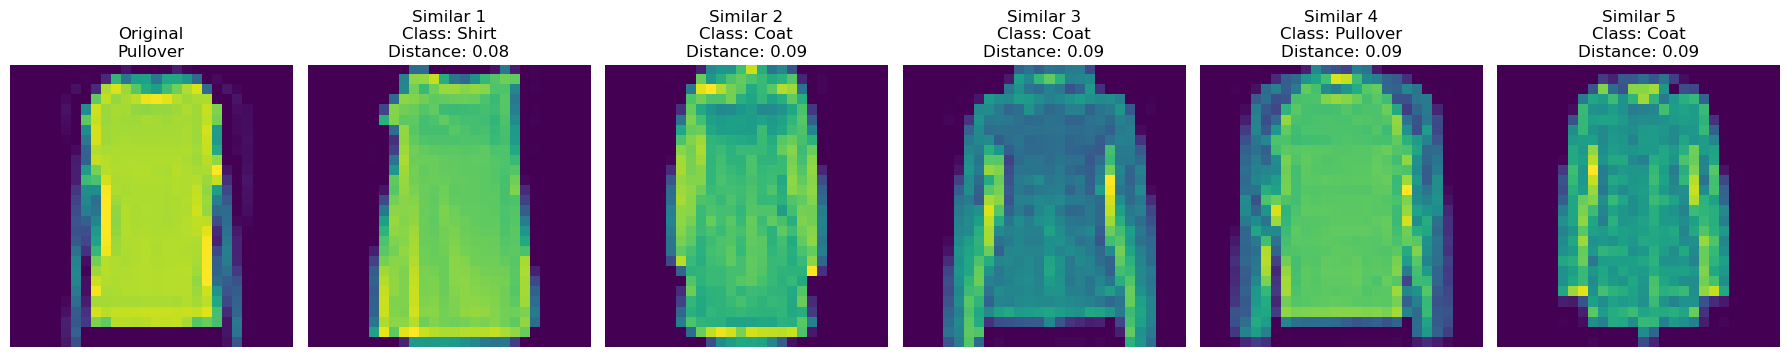

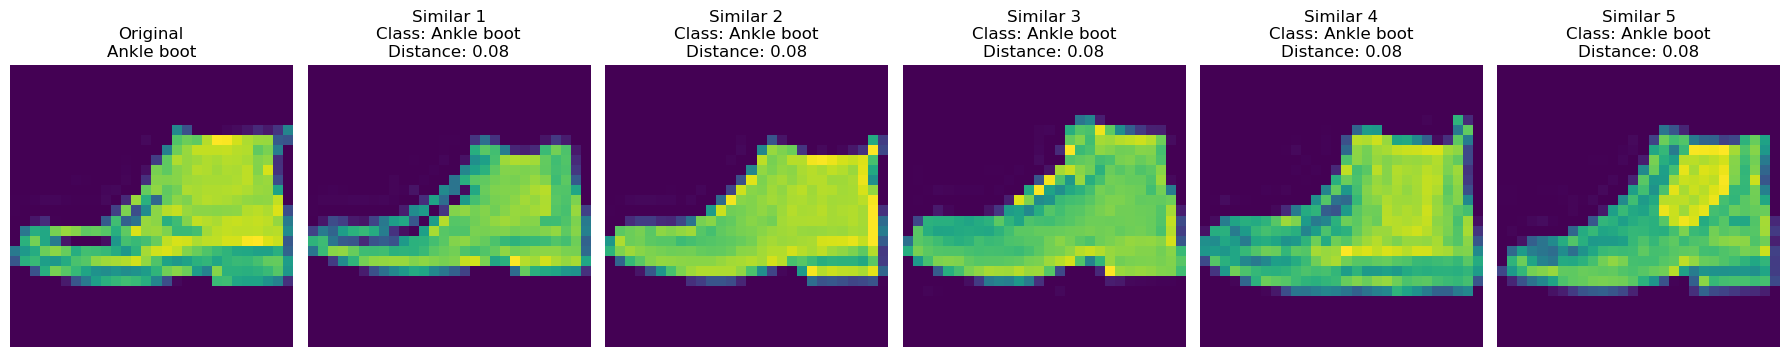

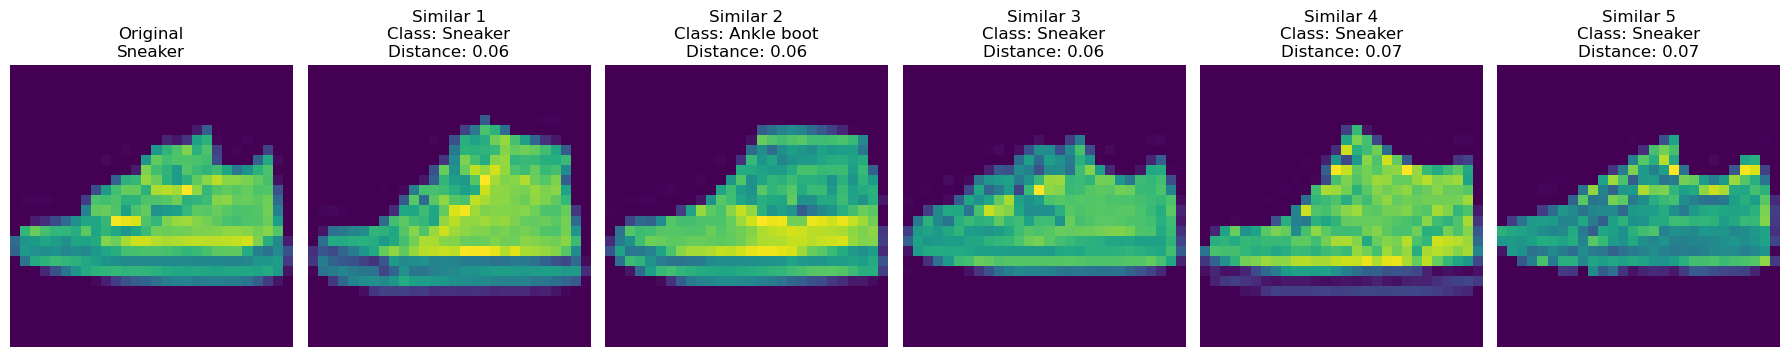

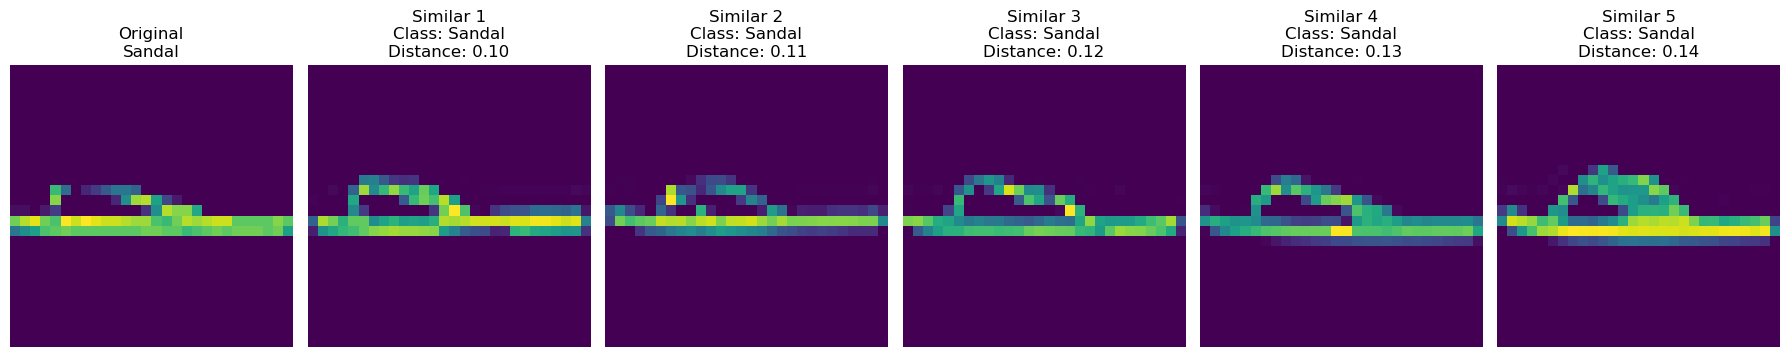

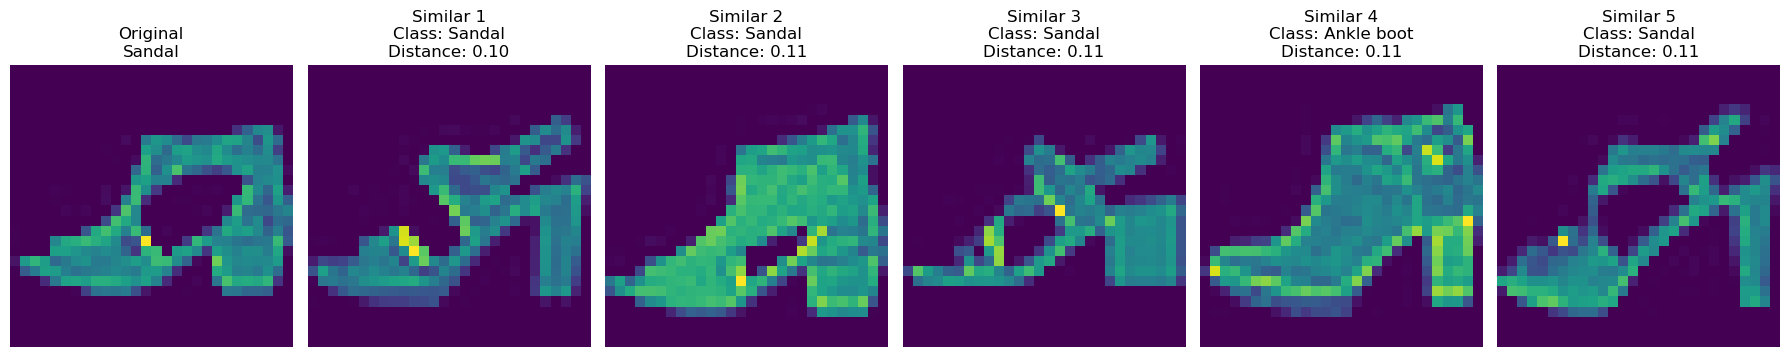


Calculating metrics



Overall Metrics Summary:

At K = 1:
Precision: 0.789
Recall: 0.002
F1-score: 0.003

At K = 2:
Precision: 0.776
Recall: 0.003
F1-score: 0.006

At K = 5:
Precision: 0.754
Recall: 0.008
F1-score: 0.015

At K = 15:
Precision: 0.715
Recall: 0.021
F1-score: 0.042

At K = 20:
Precision: 0.702
Recall: 0.028
F1-score: 0.054

At K = 30:
Precision: 0.682
Recall: 0.041
F1-score: 0.077

Per-class Metrics at K=30:

T-shirt/top:
Precision: 0.607
Recall: 0.040
F1-score: 0.075

Trouser:
Precision: 0.918
Recall: 0.050
F1-score: 0.094

Pullover:
Precision: 0.462
Recall: 0.028
F1-score: 0.052

Dress:
Precision: 0.702
Recall: 0.042
F1-score: 0.079

Coat:
Precision: 0.603
Recall: 0.037
F1-score: 0.070

Sandal:
Precision: 0.689
Recall: 0.042
F1-score: 0.079

Shirt:
Precision: 0.386
Recall: 0.024
F1-score: 0.044

Sneaker:
Precision: 0.841
Recall: 0.049
F1-score: 0.093

Bag:
Precision: 0.696
Recall: 0.043
F1-score: 0.080

Ankle boot:
Precision: 0.877
Recall: 0.052
F1-score: 0.098
Model saved successfully!


In [9]:
# Function to train the resnet model and evaluate metrics
def main(sample_size=5000):
    # Initialize ResNet101 model
    model = ResNet101(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

    # Preprocess images
    print("Images are being prepocessed")
    processed_images = preprocess_fmnist(x_train, sample_size)

    # Extract features
    print("Feature extraction in progress")
    features = extract_features(processed_images, model)

    # Find nearest neighbors
    print("Finding nearest neighbors")
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean').fit(features)

    # Show similar images for random examples
    for _ in range(5):
        random_idx = random.randint(0, sample_size-1)
        distances, indices = neighbors.kneighbors([features[random_idx]])
        plot_similar_images(random_idx, indices[0][1:], distances[0][1:],
                          x_train[:sample_size], y_train[:sample_size])

    # Calculate and display metrics
    print("\nCalculating metrics")
    k_values = [1, 2, 5 ,15, 20, 30]
    metrics = calculate_metrics(features, y_train[:sample_size], k_values)
    print_metrics_summary(metrics, k_values)

    #Save model
    model.save("Resnet_10ksamples.h5")
    print("Model saved successfully!")


if __name__ == "__main__":
    main(sample_size=5000)